In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
import os
from PIL import Image, ImageOps
import scipy.ndimage

In [2]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

In [3]:
localmapping = {
    0 : 11 ,
    1 : 12 ,
    2 : 13 ,
    3 : 16 ,
    4 : 18 ,
    5 : 19 ,
    6 : 1 ,
    7 : 20 ,
    8 : 21 ,
    9 : 22 ,
    10 : 23 ,
    11 : 25 ,
    12 : 26 ,
    13 : 27 ,
    14 : 28 ,
    15 : 29 ,
    16 : 2 ,
    17 : 31 ,
    18 : 32 ,
    19 : 33 ,
    20 : 34 ,
    21 : 35 ,
    22 : 36 ,
    23 : 6 ,
    24 : 7 ,
    25 : 8 ,
}

In [4]:
mapping={
    1:"क", 2:"ख", 3:"ग", 4:"घ", 5:"ङ",
    6:"च", 7:"छ", 8:"ज", 9:"झ", 10:"ञ",
    11:"ट", 12:"ठ", 13:"ड", 14:"ढ", 15:"ण",
    16:"त", 17:"थ", 18:"द", 19:"ध", 20:"न",
    21:"प", 22:"फ", 23:"ब", 24:"भ", 25:"म",
    26:"य", 27:"र", 28:"ल", 29:"व", 30:"श", 31:"ष",
    32:"स", 33:"ह",34:"क्ष", 35:"त्र", 36:"ज्ञ",
    37:"अ", 38:"आ", 39:"इ", 40:"ई", 41:"उ", 42:"ऊ", 43:"ऋ", 44:"ए", 45:"ऐ", 46:"ओ", 47:"औ",
    48:"अं" , 49:"अ:"
}

In [5]:
def predictletter(img):
    #show(img)
    img  = img.reshape(1,32,32,1)
    img = img/255
    i = model.predict(img)
    i = np.argmax(i)
    ans = mapping[localmapping[i]]
    return ans

def show(img):
    print(img.shape)
    plt.imshow(img, cmap=plt.get_cmap('gray_r'))
    plt.show()

In [6]:
def border(thresh):
    #print(thresh)
    """"
    bg_test = np.array([thresh[i][i] for i in range(5)])
    if bg_test.all() == 0:
        text_colour = 255
        bg_colour = 0
    else:
        text_colour = 0
        bg_colour = 255
    """
    text_colour = 255
    bg_colour = 0
    image = thresh[:]
    count = 0
    bg = np.full((1,thresh.shape[1]), bg_colour)
    for r in range(1,thresh.shape[0]):
        if(np.equal(bg_colour,image[r]) ).all() == True:
            count +=1
        else:
            break
    return count

In [7]:
def getcroppedimage(thresh):
    top = border(thresh)
    
    flip = cv2.flip(thresh,0)
    bottom = thresh.shape[0] - border(flip)
    
    flipright = cv2.flip(thresh.T,0)
    right = thresh.shape[1] - border(flipright)
    
    
    flipleft = cv2.flip(flipright,0)
    left = border(flipleft)
    
    "make rect"
    #sample = thresh.copy()
    #cv2.rectangle(sample,(left,top),(right,bottom),(255,255,255),1)
    #extra = int((bottom - top)*2/10)
    #cv2.rectangle(sample,(left - extra,top-extra),(right+extra,bottom+extra),(255,255,255),1)
    
    cropped = thresh[top:bottom, left:right]
    return cropped

In [8]:
def getrotatedimage(cropped,text_colour):
    angle = 0
    maxcount = 0
    toprow = 0
    for theta in range(-10,10):
        temp = imutils.rotate_bound(cropped, theta)
        for i in range(int(temp.shape[0]/3.5)):
            count  = 0
            for j in range(temp.shape[1]):
                if temp[i][j] == text_colour:
                    count+=1
            if count > maxcount:
                maxcount = count
                toprow = i
                angle = theta
    
    
    rotated = imutils.rotate_bound(cropped, angle)
    #rotated = getcroppedimage(rotated)
    return (rotated, toprow)

In [9]:
def segmentation(img):
    bg_colour = img[1]
    temp = img[0]
    es = []
    es.append(0)
    bg = np.repeat(bg_colour, temp.shape[0], )
    for col in range(1,temp.shape[1]):
        if(np.equal(bg,temp[:,col]).all()):
            es.append(col)
            
    es.append(temp.shape[1] - 1)
    es = np.array(es)
    #print(es)
    
    margin = int(temp.shape[1]*3/100)
    
    newsegments = []
    for i in range(0,es.shape[0]-1):
        if es[i+1]-es[i] > margin:
            newsegments.append((es[i], es[i+1]))
            #newsegments.append(es[i+1])
    
    return newsegments

In [10]:
def recognition(img, bg_colour):
    img = getcroppedimage(img)
    #show(img)
    
    border = 10
    if img.shape[1]>img.shape[0]:
        x = img.shape[1]
        y = img.shape[0]
        extra = x - y
        a = int(extra/2)
        b = int((extra+1)/2)
        top = np.full((x+2*border,x+2*border), bg_colour)
        top[a+border:a+y+border,border:border+x] = img[:]
        
    else:
        x = img.shape[0]
        y = img.shape[1]
        extra = x - y
        a = int(extra/2)
        b = int((extra+1)/2)
        top = np.full((x+2*border,x+2*border), bg_colour)
        top[border:border+x,a+border:a+y+border] = img[:]
        
    
    basewidth = 32
    img = Image.fromarray(top)
    #show(top)
    img = img.resize((basewidth, basewidth), Image.ANTIALIAS)
    img = ImageOps.grayscale(img) 
    img = np.array(img)
    
    return img

In [11]:
def extract(rotated,segments, bg_colour):
    s = ''
    for segment in segments:
        #print(segment[0])
        #print(segment[1])
        img = rotated[:,segment[0]:segment[1]]
        #show(img)
        final = recognition(img, bg_colour)
        #show(final)
        ans =predictletter(final)
        s+= ans
    return s

In [12]:
def binaryconversion(img):
    "image defining"
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    #show(blur)
    
    
    #ret,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    
    "get bg colour"
    #bg_test = np.array([thresh[i][i] for i in range(10)])
    bg_test = []
    for i in range(blur.shape[0]):
        for j in range(blur.shape[1]):
            #print(blur[i][j])
            if blur[i][j] > 50:
                bg_test.append(0)
            else:
                bg_test.append(255)
    
    bg_test = np.array(bg_test)   
    #print(bg_test)
    print(np.argmax(np.bincount(bg_test)))
    if np.argmax(np.bincount(bg_test)) == 0:
        ret,thresh = cv2.threshold(blur,100,255,cv2.THRESH_BINARY_INV)
        #thresh = cv2.bitwise_not(thresh)
    else:
        ret,thresh = cv2.threshold(blur,170,255,cv2.THRESH_BINARY_INV)
        thresh = cv2.bitwise_not(thresh)
        
    return thresh

In [13]:
def binaryconversion2(img):
    "image defining"
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    ret,blur = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    
    "get bg colour"
    #bg_test = np.array([thresh[i][i] for i in range(10)])
    bg_test = []
    for i in range(blur.shape[0]):
        for j in range(blur.shape[1]):
            bg_test.append(blur[i][j])
    
    bg_test = np.array(bg_test)   
    #print(bg_test)
    #rint(np.argmax(np.bincount(bg_test)))
    if np.argmax(np.bincount(bg_test)) == 0:
        ret,thresh = cv2.threshold(blur,100,255,cv2.THRESH_BINARY_INV)
        thresh = cv2.bitwise_not(thresh)
    else:
        ret,thresh = cv2.threshold(blur,170,255,cv2.THRESH_BINARY_INV)
        #thresh = cv2.bitwise_not(thresh)
        
    return thresh

In [14]:
def preprocess(img):
       
    thresh = binaryconversion2(img)
    bg_colour = 0
    text_colour = 255

    "erode and dialate"
    #show(thresh)
    kernel = np.ones((3,3),np.uint8)
    erode = cv2.erode(thresh , kernel, iterations = 1)
    #show(erode)
    newkernel = np.ones((5,5),np.uint8)
    thresh = cv2.dilate(erode, newkernel, iterations = 1)
    #show(thresh)
    
    thresh2 = scipy.ndimage.median_filter(thresh, (5, 1)) # remove line noise
    thresh2 = scipy.ndimage.median_filter(thresh2, (1, 5)) # weaken circle noise
    thresh2 = scipy.ndimage.median_filter(thresh2, (5, 1)) # remove line noise
    thresh = scipy.ndimage.median_filter(thresh2, (1, 5)) # weaken circle noise
    
    #print(bg_colour)
    #show(erode)
    " get cropped image"
    cropped = getcroppedimage(thresh)
    #show(cropped)
    
    "get rotated image"
    x = getrotatedimage(cropped, text_colour)
    rotated = x[0]
    toprow = x[1]
    #show(rotated)
    
    "remove top line"
    #print(toprow)
    extra = int(rotated.shape[0]/15)
    notopline = rotated[toprow+extra:rotated.shape[0], :]
    #show(notopline)

    return [notopline,bg_colour,rotated]


In [32]:
def predict(img):
    #path = os.path.join(path)
    #img  = cv2.imread(path)
    process  = preprocess(img)
    #show(process[0])
    rotated = process[2]
    show(rotated)
    #print(process[1])
    segments = segmentation(process)
    #print(segments)
    ans = extract(rotated,segments, process[1])
    print(ans)

(319, 733)


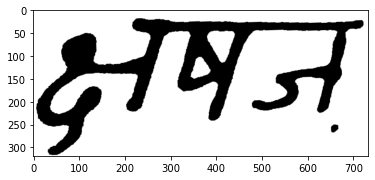

क्षषज


In [33]:
predict(cv2.imread('10.jpeg'))